Please note that this document reads from a folder directory called results_dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#MAY NEED TO RUN A COUPLE OF TIMES IF IT SAYS TO RESTART THE RUNTIME
#Import statements
from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import matplotlib.pyplot as plt # this is for plotting (showing) images
from skimage import measure
import matplotlib as mpl

import cv2
import sklearn
import tensorflow as tf
!pip install opencv-contrib-python==3.4.2.17

from sklearn.neighbors import KDTree

In [ ]:
#Get the saved card images from the train-XXX.jpg image files from the drive and save them in a list
cards_train = []
for j in range(1, 17):
    #Read the image (as BGR by default) 
    im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train1, ' + str(j) + '.jpg')
    #Convert image to RGB
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    #Add numpy RGB form of image to the list
    im_rgb = np.asarray(im_rgb)
    cards_train.append(im_rgb)
for i in range(2, 11):
    for j in range(1, 19):
        im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train' + str(i) + ', ' + str(j) + '.jpg')
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        im_rgb = np.asarray(im_rgb)
        cards_train.append(im_rgb)
for i in range(12, 14):
    for j in range(1, 19):
        im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train' + str(i) + ', ' + str(j) + '.jpg')
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        im_rgb = np.asarray(im_rgb)
        cards_train.append(im_rgb)
for j in range(1, 12):
    im_bgr = cv2.imread('drive/My Drive/CS413_IVA_Coursework/results_dir/train14, ' + str(j) + '.jpg')
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = np.asarray(im_rgb)
    cards_train.append(im_rgb)

In [ ]:
#Stores the labels of each card image in the order that they are saved to the drive
#Each new image starts on a new line
labels = [5, 67, 52, 35, 40, 18, 31, 47, 52, 33, 210, 33, 54, 63, 26, 36, 33, 48,
73, 57, 57, 54, 89, 17, 60, 66, 54, 57, 76, 33, 68, 25, 68, 33, 63, 83,
36, 56, 65, 89, 44, 4, 96, 15, 59, 15, 63, 11, 69, 1, 89, 1, 62, 56,
54, 17, 89, 57, 57, 73, 76, 57, 54, 66, 33, 60, 68, 63, 33, 25, 83, 68,
31, 26, 48, 36, 33, 54, 52, 67, 52, 210, 47, 33, 40, 18, 35, 33, 63, 5,
7, 92, 63, 96, 54, 11, 42, 82, 24, 45, 37, 11, 98, 21, 65, 28, 2, 24,
160, 150, 177, 192, 161, 87, 138, 164, 183, 124, 190, 104, 101, 135, 115, 142, 168, 114,
109, 147, 139, 136, 106, 129, 146, 186, 182, 109, 154, 108, 198, 151, 127, 189, 108, 146,
196, 134, 174, 103, 198, 192, 114, 190, 147, 182, 154, 192, 142, 146, 148, 133, 174, 191,
172, 133, 134, 182, 171, 120, 181, 172, 189, 156, 111, 181, 139, 106, 156, 184, 139, 131,
150, 162, 165, 139, 139, 121, 139, 112, 125, 112, 136, 170, 127, 135, 181, 114, 109, 198,
121, 193, 168, 162, 119, 112, 151, 187, 104, 121, 168]

In [ ]:
#Use sift to get the keypoints and descriptors of each image card from a train-XXX.jpg file
sift = cv2.xfeatures2d.SIFT_create()
kps = []
descs = []
#The lists contain a list for each image 
for i in range(len(cards_train)):
    kp, des = sift.detectAndCompute(cards_train[i], None)
    kps.append(kp)
    descs.append(des)

In [ ]:
#Counts the number of good matches (those that survive Lowes pruning strategy) between two images
def count_matchings(img1, img2):
    #Use a KD tree to make it faster
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    #Make FLANN searcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    #Get the descriptors of each image
    des1 = descs[img1]
    des2 = descs[img2]

    #Find the matches
    matches = flann.knnMatch(des1, des2, k = 2)

    #Count the number of good matches (those that survive Lowes pruning strategy)
    good_matches = 0
    for match in matches:
        if (match[0].distance < match[1].distance * 0.7):
            good_matches = good_matches + 1
    
    return good_matches

In [ ]:
#Determines whether two cards are similar or not (based on a threshold for the number of good matches)
def similarity_check(im1, im2):
    #If there are enough good matches then output "Yes"
    num_matchings = count_matchings(im1, im2)
    if (num_matchings >= 731):
        return "Yes"
    else:
        return "No"

In [ ]:
#Finds the M closest images to a given image
def find_M_closest_images(img1, M):
    #Stores the number of matches of the image with all other images
    matches = np.zeros(225 - 16)

    #Count and store the number of matches of the image with every other image
    for img2 in range(16, 225):
        num_matches = count_matchings(img1, img2)
        matches[img2 - 16] = num_matches
    
    #Find the M images with the most matches
    max_indices = []
    for i in range(M):
        current_max_index = matches.argmax()
        max_indices.append(current_max_index + 16)
        #Prevents the same cards being chosen again
        matches[current_max_index] = -1
    
    return max_indices

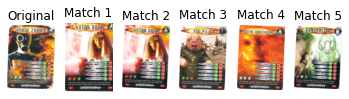

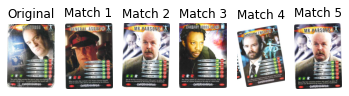

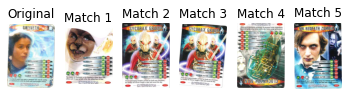

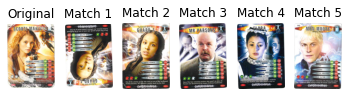

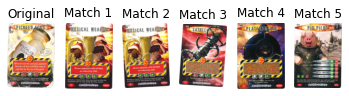

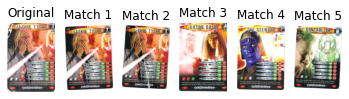

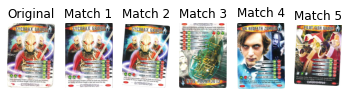

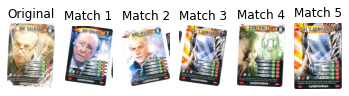

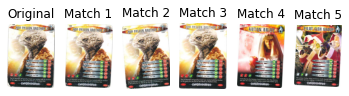

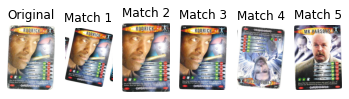

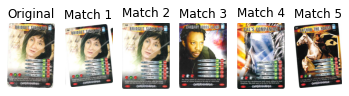

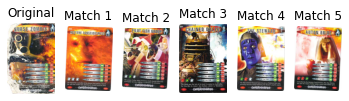

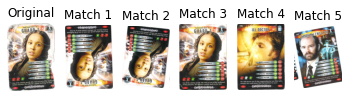

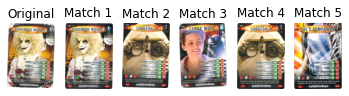

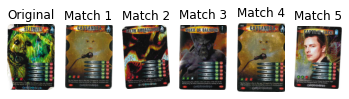

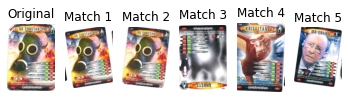

In [ ]:
#Choose a value for M
M = 5

#Find the M "closest" image cards from train-002.jpg to train-014.jpg to each of the image cards in train-001.jpg
for i in range(16):
    #Find the M closest cards to image i
    closest_images = find_M_closest_images(i, M)

    #Plot the original card
    plt.subplot(1, M+1, 1)
    plt.imshow(cards_train[i])
    plt.axis('off')
    plt.title('Original')

    #Plot and label the M closest cards
    for j in range(M):
        plt.subplot(1, M+1, j+2)
        plt.imshow(cards_train[closest_images[j]])
        plt.axis('off')
        plt.title('Match ' + str(j+1))

    plt.show()